In [52]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('../')
from utils import quant, symbols
from utils.quant import detrend1, norm1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import yfinance as yf
import ta
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from neurodsp import sim #for brownian motion 
from math import log, floor
import random
import tensorflow as tf

from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# State Spaces
Find [causally] related stocks either by sector or by SSA component cluster (other notebook)
- Want to detrend inflationary (exponential?) trend, as well as apply fourier transform to possibly reduce noise
https://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly

Unrelated stuff: also exploring with weather data to play with attractors

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


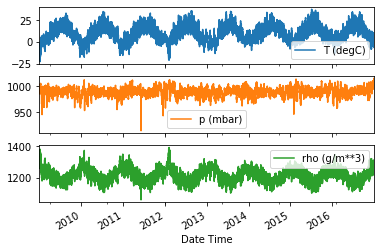

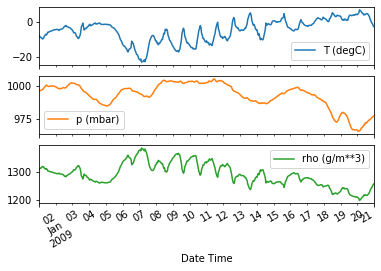

In [4]:
msft = yf.download('MSFT', '2012-10-01','2020-9-30')
aapl = yf.download('AAPL', '2012-10-01','2020-9-30')
tsla = yf.download('TSLA', '2012-10-01','2020-9-30')

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df = df[5::6]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

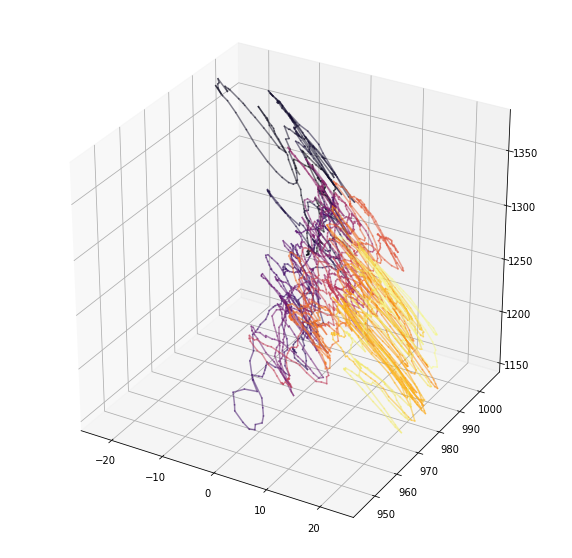

In [14]:
cutoff=3000
quant.draw_phase_space(list(df['T (degC)'])[:cutoff], list(df['p (mbar)'])[:cutoff],list(df['rho (g/m**3)'])[:cutoff])
plt.show()

# Detrend

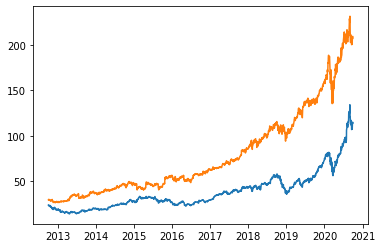

In [22]:
#TSLA = yf.download('TSLA', '2012-10-01','2020-9-30')
plt.figure()
for t in [aapl,msft]:
    plt.plot(t['Close'])
    y = np.polyfit(np.log(t['Close']), t['Close'], 1)
    f = lambda x: y[0]*np.log(x) + y[1]
    x=np.linspace(0,len(aapl),100)
    #plt.plot(x,f(x))

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


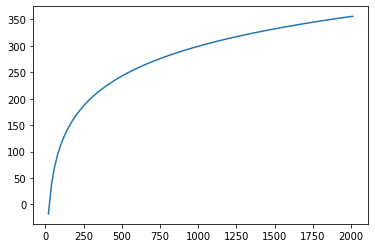

In [23]:
f = lambda x: y[0]*np.log(x) + y[1]
x=np.linspace(0,len(aapl),100)
plt.plot(x,f(x))

# PCA Manifold Style

- Not smooth compared to weather data: displays nonstationarity

In [101]:
tech = symbols.extract_tickers(sector = 'Technology')
raster = {}
i=0
while i < 20:
    t = random.randint(1, len(tech)) - 1
    stock = yf.download(tech[t], '2018-10-01','2020-9-30')
    if stock.shape == (0, 6) or len(stock['Close']) != 503: # no data found in range
        continue
    else: 
        raster[tech[t]] = list(stock['Close'])
        i+=1
        
clear_output()

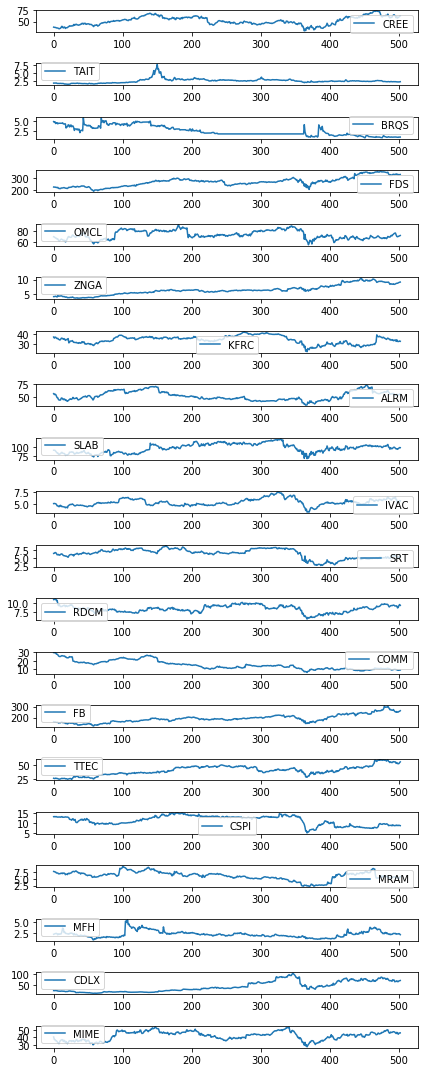

In [107]:
plt.figure(figsize=(6,15))
for i,t in enumerate(raster.keys()):
    plt.subplot(20,1,i+1)
    plt.plot(raster[t], label = t)
    plt.tight_layout()
    plt.legend()

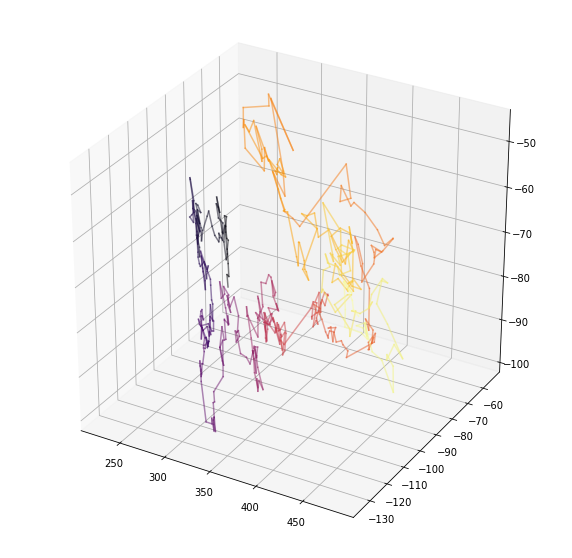

In [124]:
pca = PCA(n_components = len(raster))
data = np.array([raster[k] for k in raster.keys()])
pca.fit(data.T)
com = pca.components_
first3 = [pc@data for pc in com[:3]]

quant.draw_phase_space(*[first3[i] for i in range(3)])